In [235]:
import os
from src import *
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

"""
COMPAS:
BL   African-American    3696                          
WH   Caucasian           2454                            
HI   Hispanic             637
OT   Other                377
As   Asian                 32 (merged with Other)
Na?   Native American       18 (merged with Other)

ADULT:
IN   Amer-Indian-Eskimo  count: 311
WH   White               count: 27816
AP   Asian-Pac-Islander  count: 1039
BL   Black               count: 3124
OT   Other               count: 271
""" 

race_label = {"Caucasian":'WH', "Hispanic":"HI", "African-American": "BL",
              "White":"WH", 'Asian-Pac-Islander':"AP", "Black":"BL",
              'Amer-Indian-Eskimo':"IN", 'Other':"OT"}

other = {Tester.OPT_ALL_RACE_SPLITS: True}
Tester.VERBOSE = False
other_fb = other.copy()
other_fb[BaseModel.OPT_FBALANCE] = True
all_metrics = Metrics.get_all_names()
Metrics.OPT_PRETTY_LABELS = True

datasets =  [Tester.COMPAS_D, Tester.ADULT_D]
mls_basic = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       None,    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, None,    other)
}

Y_LABEL = None
Y_LABELSUPER = None
X_LABEL = None
X_LABELSUPER = None

plot_h = 4.5


## ALL METRICS TABLE

In [236]:
# 1 file each for compas and adult tables. 
# func input: dataset, reps, metrics?, filename

def all_race_splits(dataset, reps, filename, metrics = all_metrics, clear_file = True, attrs = None):
    file = os.path.join("results",filename +".csv")
    if clear_file and os.path.exists(file): os.remove(file)
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls_basic.values()):
        oth[tester.OPT_SPLIT_RACE_COLS] = False
        oth[tester.OPT_ALL_RACE_SPLITS] = True
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)


def all_races(dataset, reps, filename, metrics = all_metrics, clear_file = True):
    file = os.path.join("results",filename +".csv")
    if clear_file and os.path.exists(file): os.remove(file)
    
    tester = Tester(file)
    for bias_mit, method, method2, pre, oth in list(mls_basic.values()): # mitigate bias for all races at once
        oth[tester.OPT_SPLIT_RACE_COLS] = True
        oth[tester.OPT_ALL_RACE_SPLITS] = False
        tester.run_test(metrics, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth)



In [237]:
make_tables = False
if (make_tables):
    uselful_metrics = Metrics.get_attribute_independant() + [Metrics.SF, Metrics.DF, Metrics.M_EOD, Metrics.M_AOD, Metrics.POS, Metrics.T_POS, Metrics.DI, Metrics.SPD ,Metrics.A_AOD, Metrics.A_EOD, Metrics.FR]
    # call both
    repetitions = 50
    # bias mitigated agaist sex and race
    all_races(Tester.COMPAS_D, repetitions, "CompasTESTING_all_races")
    all_races(Tester.ADULT_D,  repetitions, "AdultTESTING_all_races")
    # bias mitigation agaist only race
    all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING_race_splits", attrs=["race"])
    all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING_race_split", attrs=["race"])
    all_race_splits(Tester.COMPAS_D, repetitions, "CompasTESTING_race_sex")
    all_race_splits(Tester.ADULT_D,  repetitions, "AdultTESTING_race_sex")

## METRIC GRAPHS

In [238]:

def make_graph(plt,baselines: List[float], results: Dict[str,List[float]], labels: List[str], results_mit_for_all = None):
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, baselines, align='center', alpha=0.5, label = "baseline")
    #plt.xticks(y_pos, labels)
    plt.set(xticks=x_pos, xticklabels=[race_label[l] for l in labels])
    #plt.tick_params(rotation=23)
   

    for k, v in results.items():
        plt.plot(v, linestyle='--', marker='o',label="bias mit "+race_label[k]+" vs all")

    if results_mit_for_all:
        plt.plot(results_mit_for_all, c = 'k', linestyle='--', marker='o',label="bias mit for each race")

    plt.legend(bbox_to_anchor=(0, 1.15, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)
    plt.tick_params(axis="y", direction='in')
    return plt


In [239]:

def _graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    tester = Tester(os.path.join("results","history" +".csv"))
    
    bias_mit, method, method2, pre, oth = baseline
    oth[tester.OPT_SPLIT_RACE_COLS] = False
    oth[tester.OPT_ALL_RACE_SPLITS] = True
    tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
    baseline_results = tester.get_eval_for_each_race_split(metric_name)
    races = list(baseline_results.keys())

    #results = {key:list(baseline_results.values()) for key in races}
    results = {key:[] for key in races}
    bias_mit, method, method2, pre, oth = mitigation
    oth[tester.OPT_SPLIT_RACE_COLS] = False
    oth[tester.OPT_ALL_RACE_SPLITS] = True
    for race in races:
        tester.update_training_race_split(race)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        results[race] = list(tester.get_eval_for_each_race_split(metric_name).values())

    
    return list(baseline_results.values()), results, races, tester


In [240]:
def graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    baseline, results, races, _ = _graph_all_race_splits(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval)

    make_graph(plt,baseline, results, races)

    if (Y_LABEL is None) :plt.set_ylabel(metric_name)
    else : plt.set_ylabel(Y_LABEL)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt

In [248]:

def graph_all_race_splits_mit_for_all(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    baseline, results, races, tester = _graph_all_race_splits(plt,dataset, baseline, mitigation, 'race|'+metric_name, title, reps, attrs, metrics_to_eval)
    bias_mit, method, method2, pre, oth = mitigation
    oth[tester.OPT_SPLIT_RACE_COLS] = True
    oth[tester.OPT_ALL_RACE_SPLITS] = False
    new_attrs = (races).copy()
    if ("sex" in attrs):
        new_attrs.append("sex")
    tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, reps, same_data_split=(reps==1), data_preprocessing=pre, other = oth, sensitive_attr=new_attrs)
    results_mit_for_all = []
    for r in races:
        results_mit_for_all.append(tester.get_eval(r+'|'+metric_name))

    make_graph(plt,baseline, results, races, results_mit_for_all)

    if (Y_LABEL is None) :plt.set_ylabel(metric_name)
    else : plt.set_ylabel(Y_LABEL)
    plt.set_title(title)
    plt.autoscale(enable=True) 
    return plt


In [242]:


def run_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(5*plot_h, plot_h, forward=True)
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)
    fig.supylabel(Y_LABELSUPER)  # with adjusted position , x=-0.05
    fig.supxlabel(X_LABELSUPER)  # with adjusted position , x=-0.05
    plt.show()

def run_fb_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(2*plot_h, plot_h, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    plt.show()


In [243]:
def run_experiment_group_mit_for_all(reps, metric_name, mls = mls_basic, attrs = ["race"], metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(5*plot_h, plot_h, forward=True)
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_race_splits_mit_for_all(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)
    fig.supylabel(Y_LABELSUPER)  # with adjusted position , x=-0.05
    fig.supxlabel(X_LABELSUPER)  # with adjusted position , x=-0.05
    plt.show()

def run_fb_experiment_group_mit_for_all(reps, metric_name, mls = mls_basic, attrs = ["race"], metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(2*plot_h,plot_h, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_race_splits_mit_for_all(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_race_splits_mit_for_all(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    plt.show()

## GRAPH CHANGE IN METRIC

In [244]:
def make_change_graph(plt, baselines, results, races, bias_mit_race, max_val): 
    colors = cm.rainbow(np.linspace(0, 1, len(races)+1))

    ls = np.linspace(-max_val, max_val, 1000)
    zeros = np.zeros_like(ls)
    plt.plot(ls, zeros, color='0.5')
    plt.plot(zeros, ls, color='0.5')

   # plt.fill_between(ls, zeros, ls, where=(ls > zeros), color='C0', alpha=0.3, interpolate=True)
    plt.fill_between(ls, zeros, ls, color='0.5', alpha=0.05, interpolate=True)
    plt.fill_between(ls, zeros, -ls, color='0.5', alpha=0.05, interpolate=True, label= "bias decreased")
    plt.fill_between(ls, ls, zeros + max_val, where=(ls > zeros), color='g', alpha=0.05, interpolate=True, label="bias incr. favourably")
    plt.fill_between(ls, -ls, zeros + max_val, where=(ls < zeros), color='g', alpha=0.05, interpolate=True)
    plt.fill_between(ls, -ls, zeros - max_val, where=(ls > zeros), color='r', alpha=0.05, interpolate=True, label="bias incr. unfavourably")
    plt.fill_between(ls, ls, zeros - max_val, where=(ls < zeros), color='r', alpha=0.05, interpolate=True)

    # plotting only bias mit against white
    results_per_race = np.array(results[bias_mit_race]).T
    baselines_per_race = np.array(baselines).T
    first = True
    for i in range(len(races)): # bias mitigation against each race
        b, r = baselines_per_race[i], results_per_race[i]
        plt.scatter(b, r, marker='.', color= colors[i], alpha=0.4, label= "bias towards "+race_label[races[i]])

    for i in range(len(races)): # bias mitigation against each race
        b, r = baselines_per_race[i], results_per_race[i]
        if first: 
            plt.scatter(np.mean(b, axis=0),  np.mean(r, axis=0), marker='D', color= '0.3', alpha=0.5, label= "race's avg. bias")
            first = False
        plt.scatter(np.mean(b, axis=0),  np.mean(r, axis=0), marker='D', color= colors[i], s = 45)
        

    plt.legend()
    plt.legend(bbox_to_anchor=(0, 1.15, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=1)
    return plt

In [245]:
def graph_all_metric_changes(plt,dataset, baseline, mitigation, metric_name, title, reps, attrs, metrics_to_eval=all_metrics):
    results_out = None
    baselines_out = []
    max_val = 0
    for r in range(reps):   
        tester = Tester(os.path.join("results","change_history" +".csv")) 
        
        bias_mit, method, method2, pre, oth = baseline
        oth[tester.OPT_SPLIT_RACE_COLS] = False
        oth[tester.OPT_ALL_RACE_SPLITS] = True
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, 1, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        baselines = tester.get_eval_for_each_race_split(metric_name)
        baselines_vals = np.array(list(baselines.values()))
        max_val = max(max_val, np.amax(np.abs(baselines_vals)))

        baselines_out.append(baselines_vals)
        races = list(baselines.keys())
        if not results_out:
            results_out = {bias_mit_race:[] for bias_mit_race in races}

        bias_mit, method, method2, pre, oth = mitigation
        bias_mit_race =  races[0] # bias mit against white
        #for bias_mit_race in races:
        tester.update_training_race_split(bias_mit_race)
        tester.run_test(metrics_to_eval, dataset, bias_mit, method, method2, 1, same_data_split=True, data_preprocessing=pre, other = oth, sensitive_attr=attrs)
        result = np.array(list(tester.get_eval_for_each_race_split(metric_name).values()))   
        max_val = max(max_val, np.amax(np.abs(result)))
        results_out[bias_mit_race].append(result)  

    make_change_graph(plt, baselines_out, results_out, races, bias_mit_race, max_val)

    if (Y_LABEL is None) :plt.set_ylabel(metric_name + " after bias mitigation")
    else : plt.set_ylabel(Y_LABEL)
    if (X_LABEL is None) :plt.set_xlabel("baseline " + metric_name)
    else : plt.set_xlabel(X_LABEL)
    
    plt.set_title(title)
    plt.autoscale(enable=True) 
    plt.tick_params(axis="y", direction='in')
    return plt

In [246]:

def run_change_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=4)
    fig.tight_layout()
    fig.set_size_inches(5*plot_h, plot_h, forward=True)
    fig.subplots_adjust(wspace=0.2, hspace=0)
    
    ax1, ax2, ax3, ax4 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax2,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax3,Tester.ADULT_D,  mls["FM Baseline"], mls["FairMask"],    metric_name, "FairMask on Adult", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax4,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    fig.supylabel(Y_LABELSUPER)  # with adjusted position , x=-0.05
    fig.supxlabel(X_LABELSUPER)  # with adjusted position , x=-0.05
    plt.show()

def run_change_fb_experiment_group(reps, metric_name, mls = mls_basic, attrs = None, metrics_to_eval=all_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    fig.set_size_inches(14, 7, forward=True)
    ax1, ax2 = axes.flatten()

    graph_all_metric_changes(ax1,Tester.COMPAS_D, mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on COMPAS", reps, attrs, metrics_to_eval)
    graph_all_metric_changes(ax2,Tester.ADULT_D,  mls["FB Baseline"], mls["FairBalance"], metric_name, "FairBalance on Adult", reps, attrs, metrics_to_eval)

    plt.show()

## RUNNING EXPERIMENTS

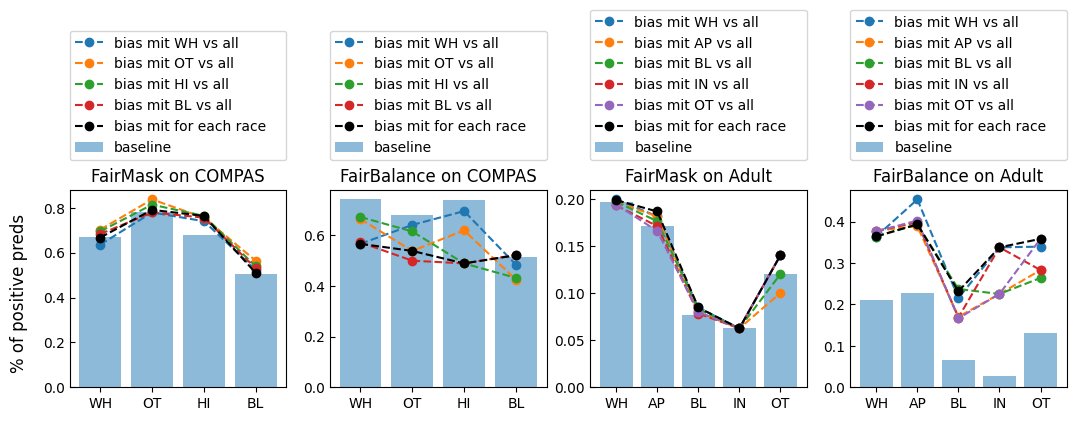

In [192]:
reps = 1
plot_h = 2.25
metric = Metrics.POS
Y_LABEL= " "
Y_LABELSUPER = "% of positive preds"
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])



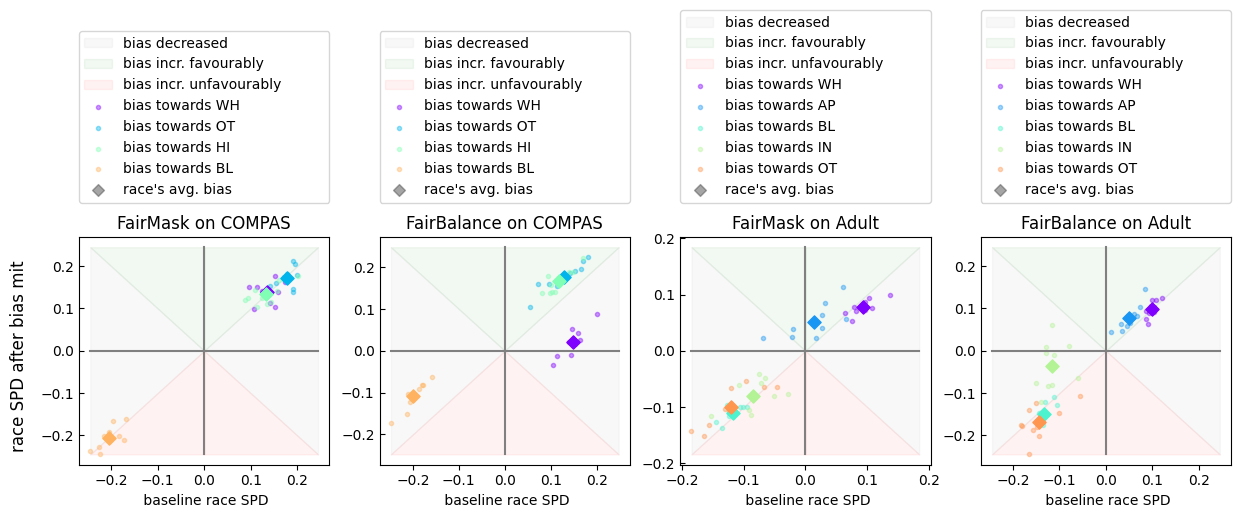

In [209]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 10
metric = 'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
plot_h = 2.6
Y_LABEL= " "
Y_LABELSUPER = "race SPD after bias mit"
X_LABEL= " baseline race SPD"
X_LABELSUPER = " "
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

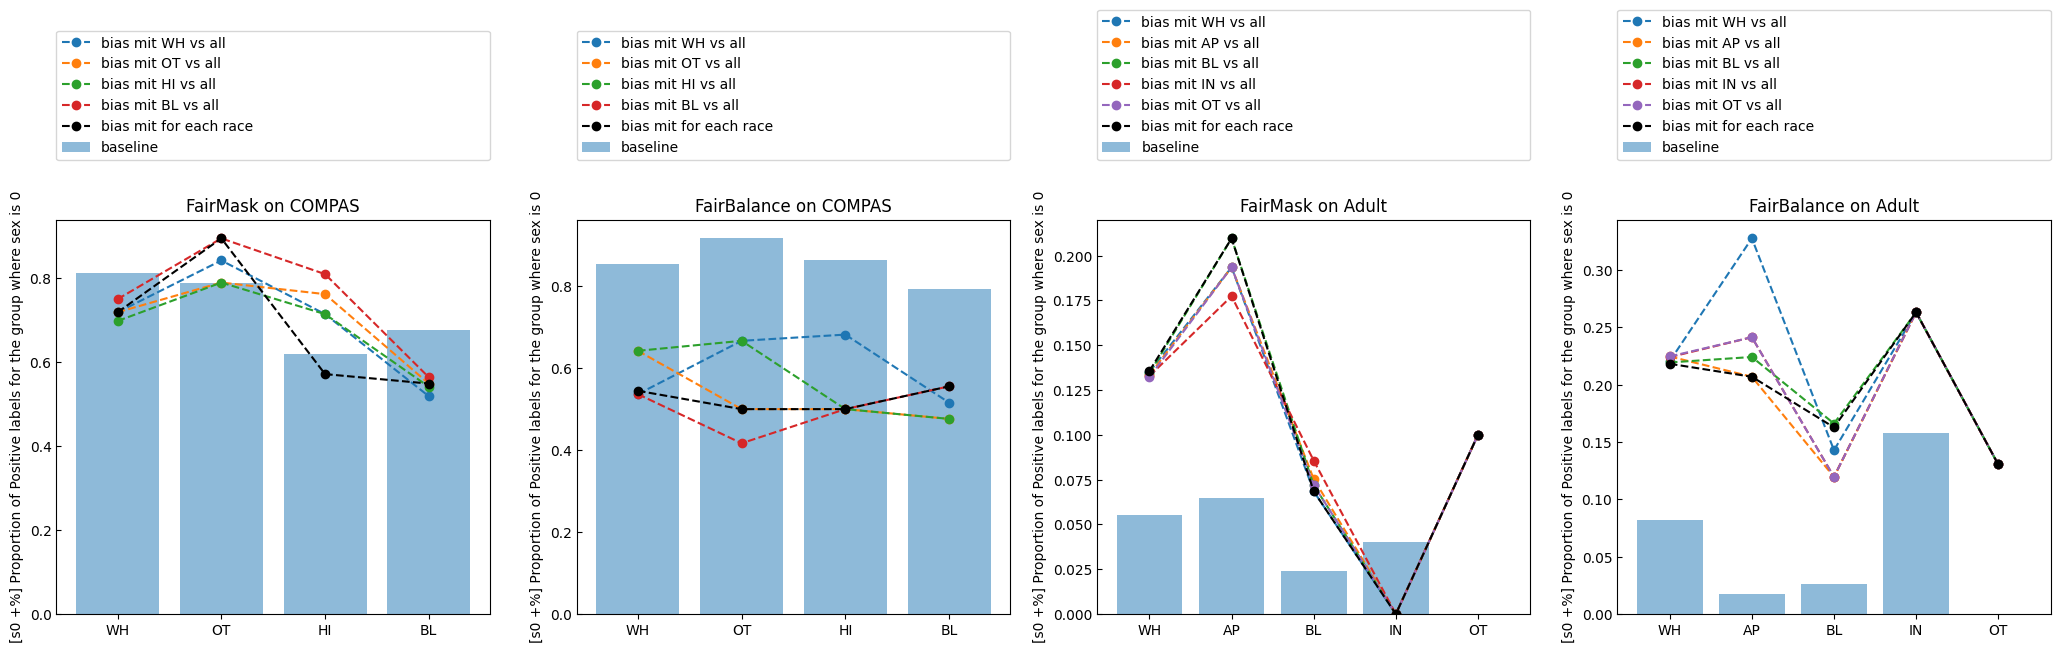

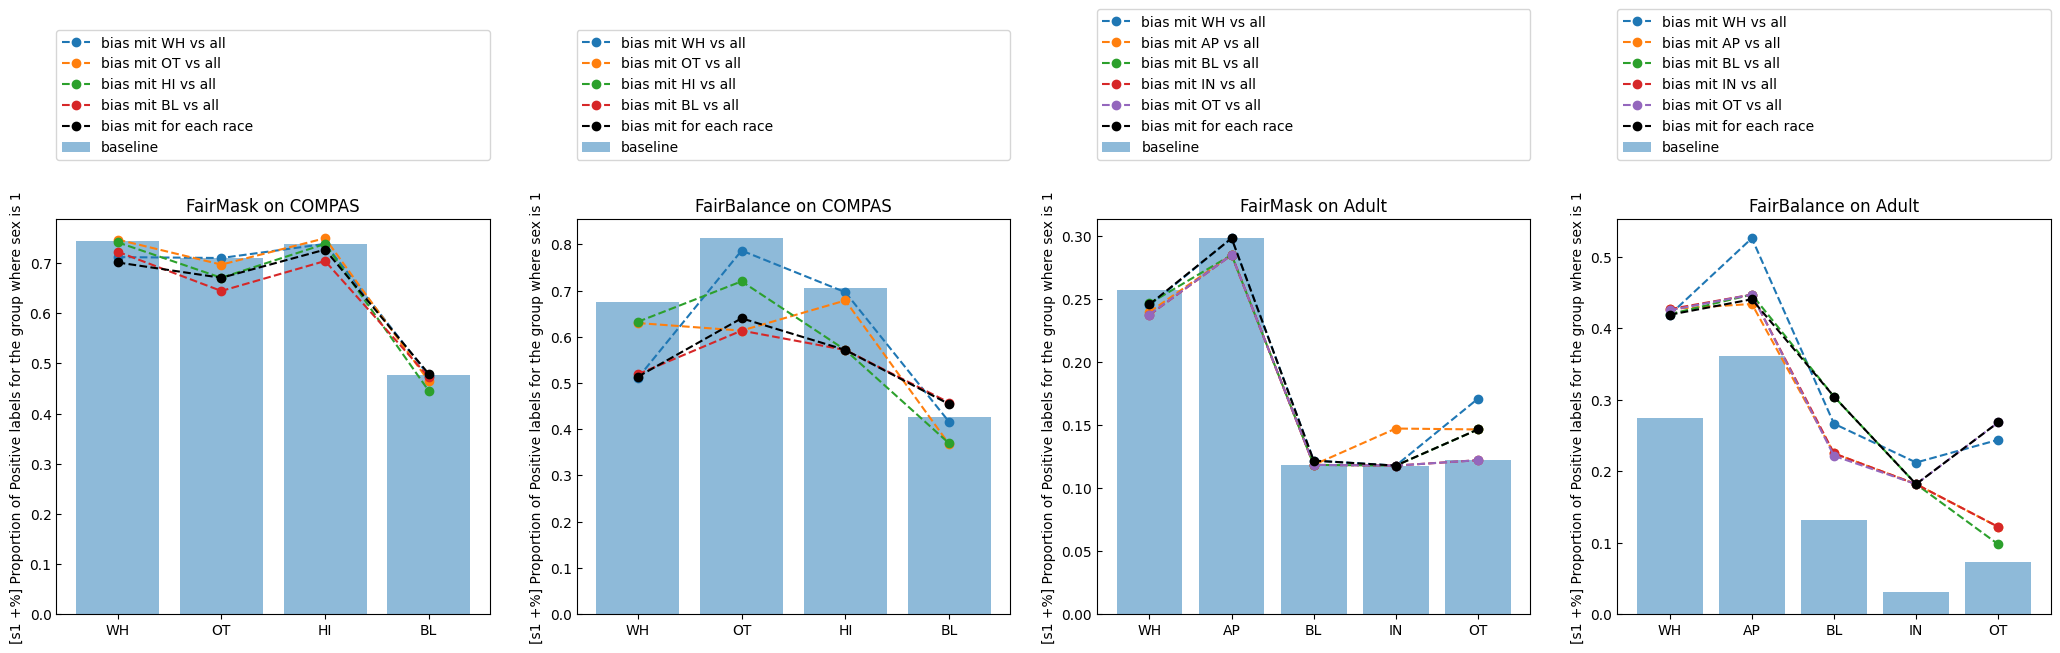

In [251]:
reps = 1
plot_h = 2.25
metric = Metrics.POS_SEX0
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric], attrs=["race", "sex"])
metric = Metrics.POS_SEX1
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric], attrs=["race", "sex"])

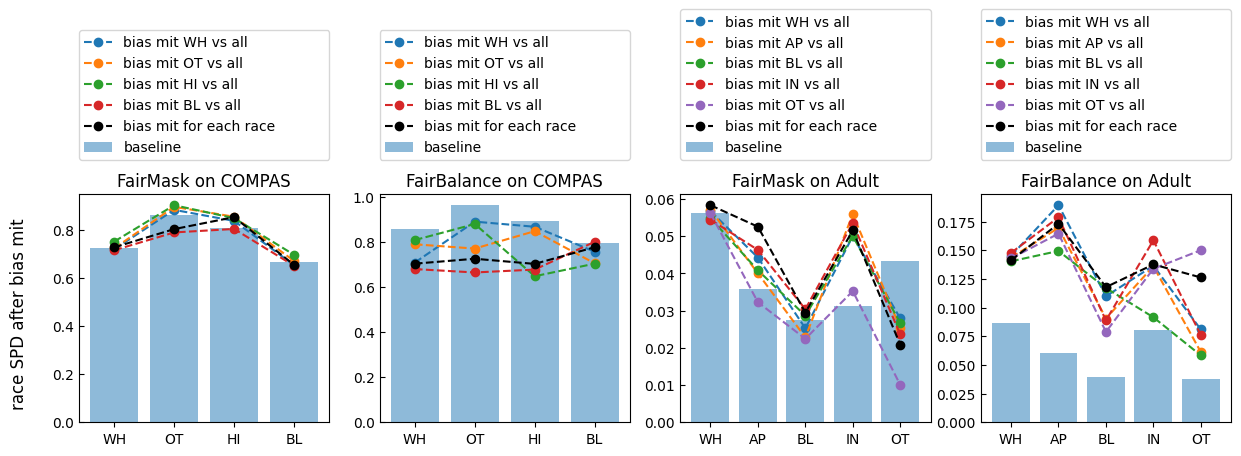

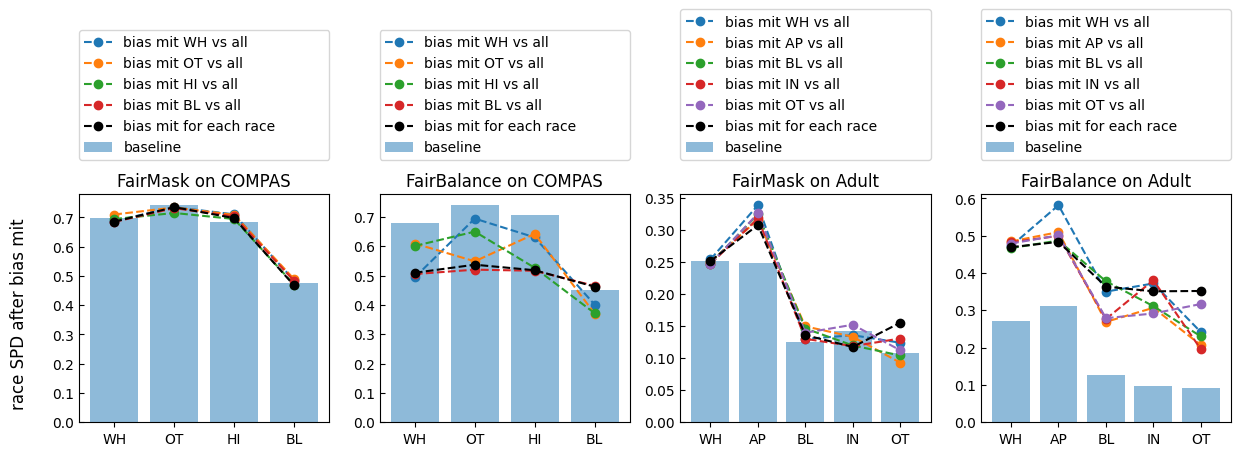

In [210]:
reps = 10
metric = Metrics.POS_SEX0
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])
metric = Metrics.POS_SEX1
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

In [ ]:
reps = 1
metric = Metrics.EOD
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

In [ ]:
reps = 1
metric = Metrics.POS
run_experiment_group_mit_for_all(reps, metric, metrics_to_eval=[metric])

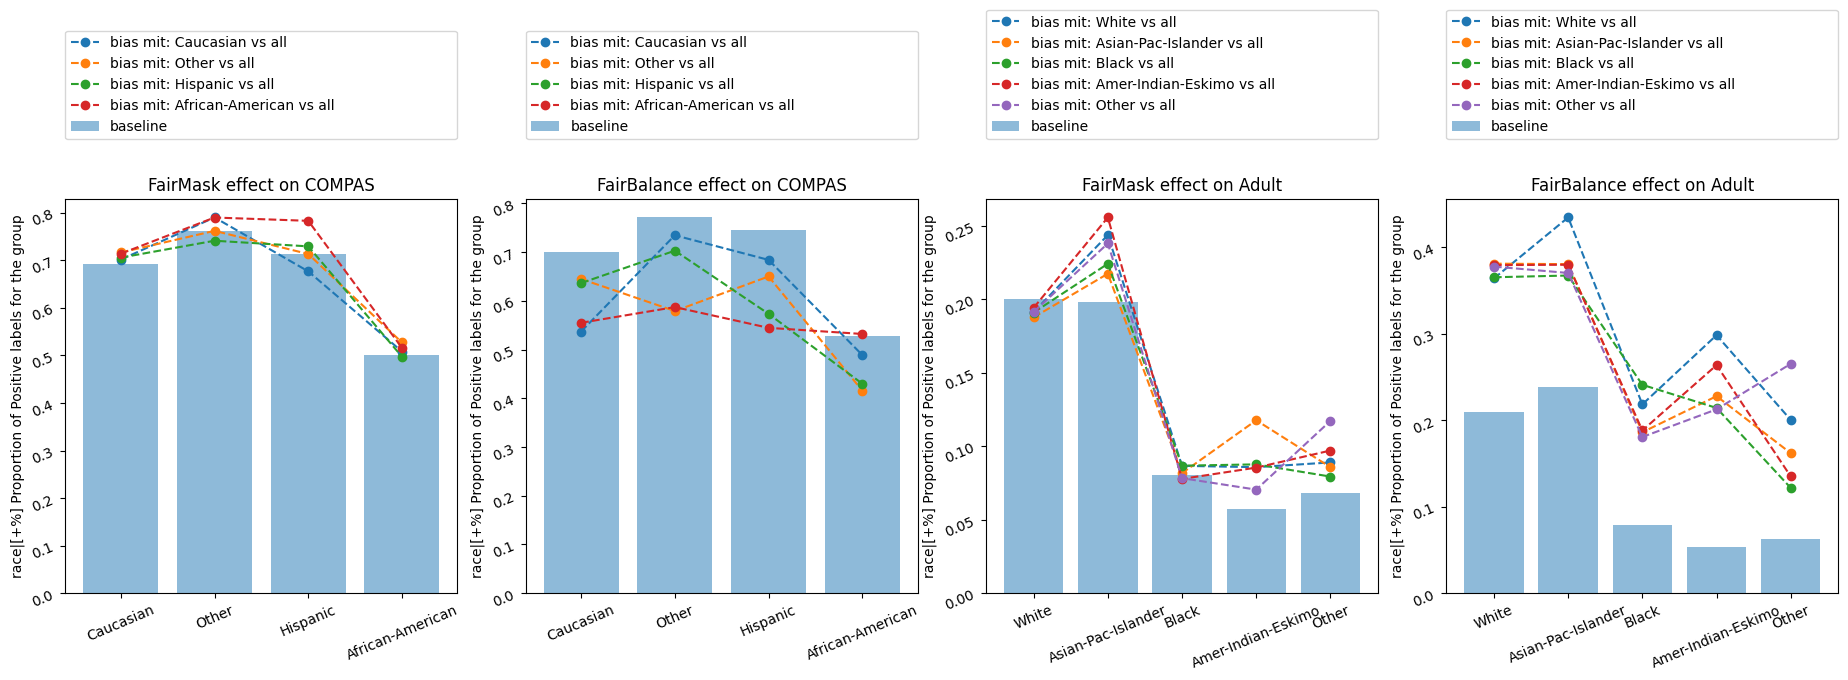

In [ ]:
# proportion of positive lables for each race for one run
reps = 5
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_experiment_group(reps, metric, attrs =  ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
##run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

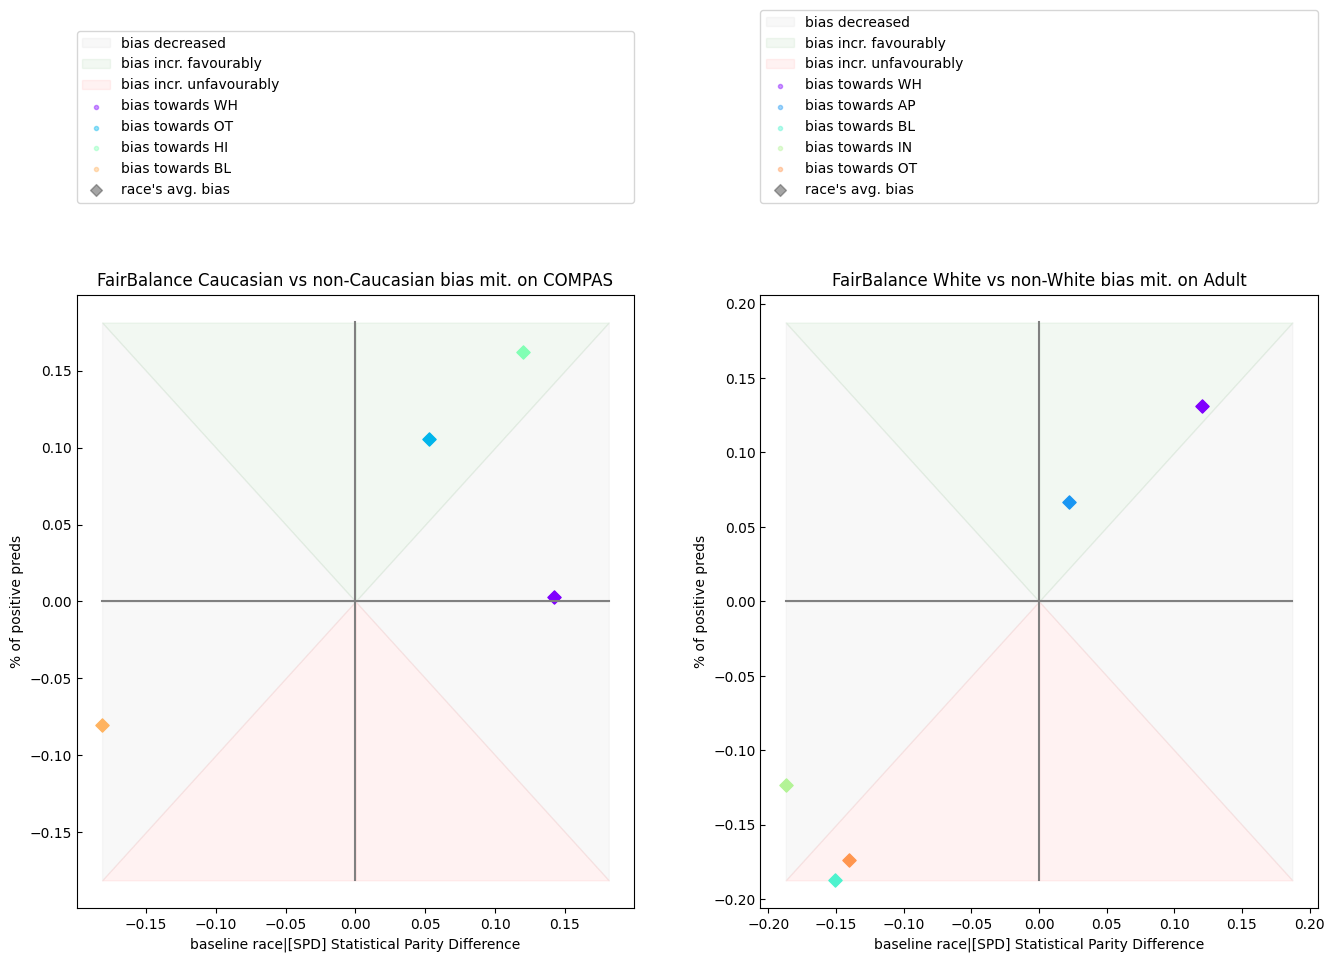

In [ ]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 1
metric = 'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
run_change_fb_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

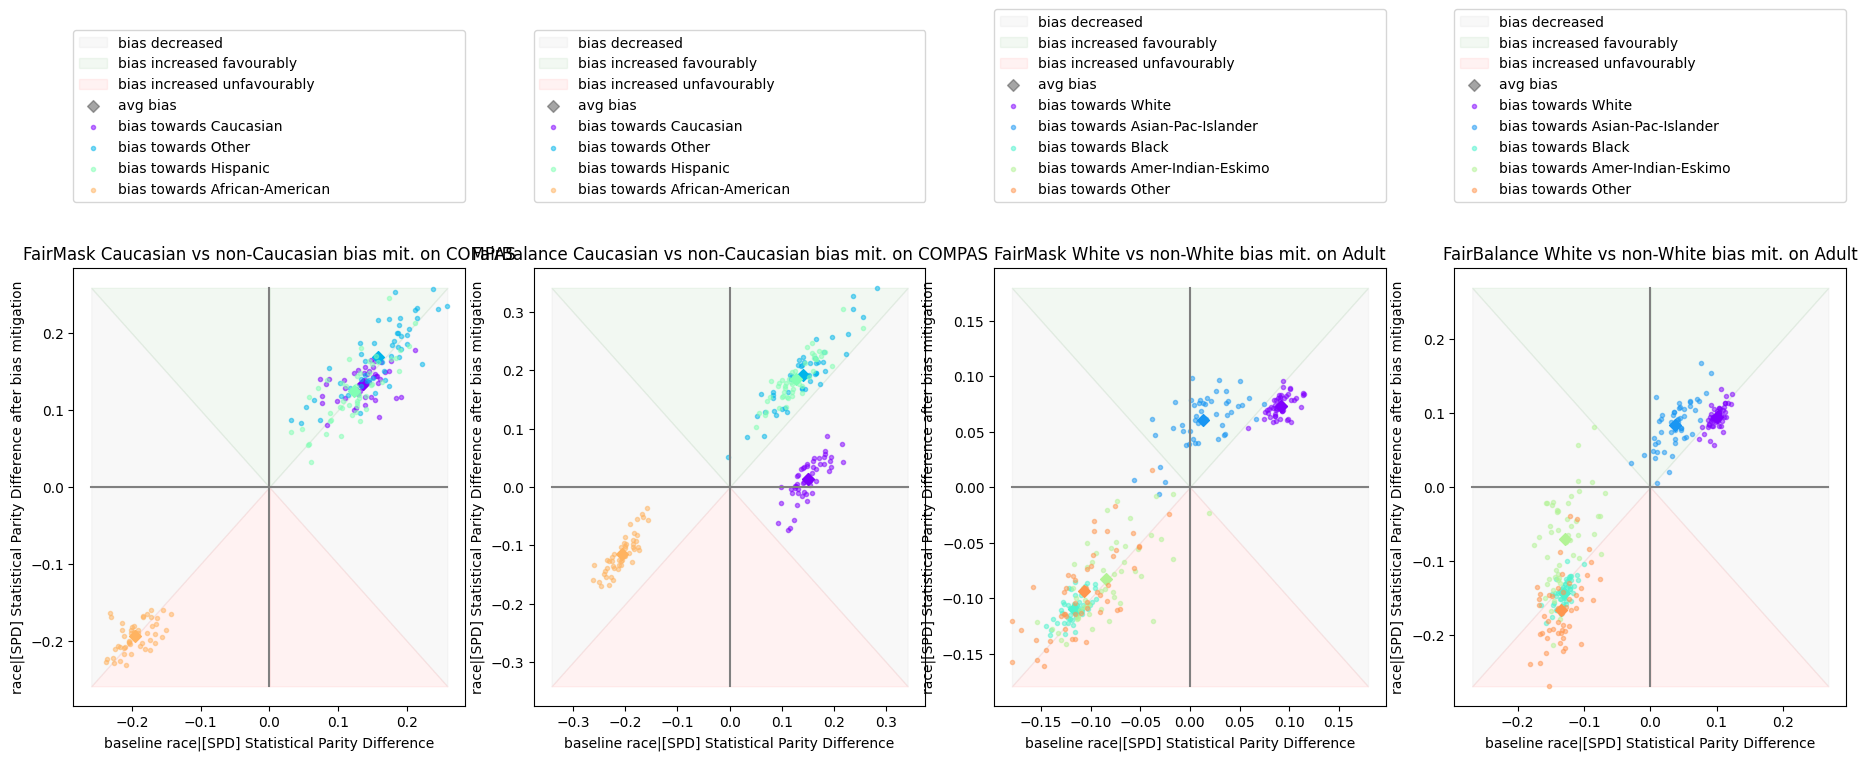

In [ ]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 50
metric = 'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

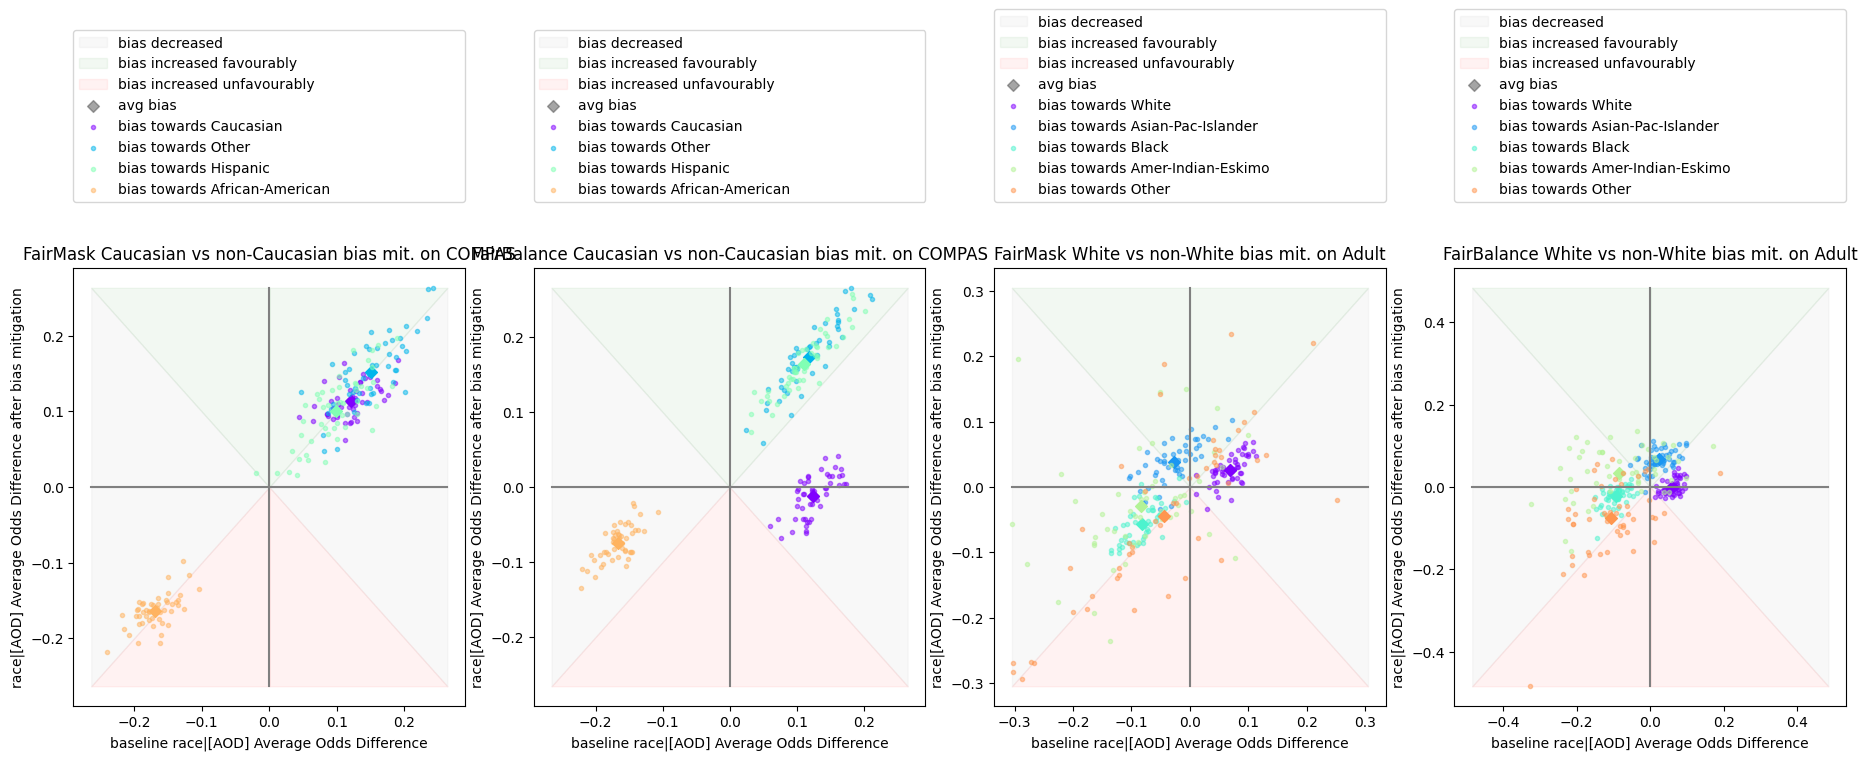

In [ ]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 50
metric = 'race|'+Metrics.AOD
m_to_eval = Metrics.AOD
run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
#run_change_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

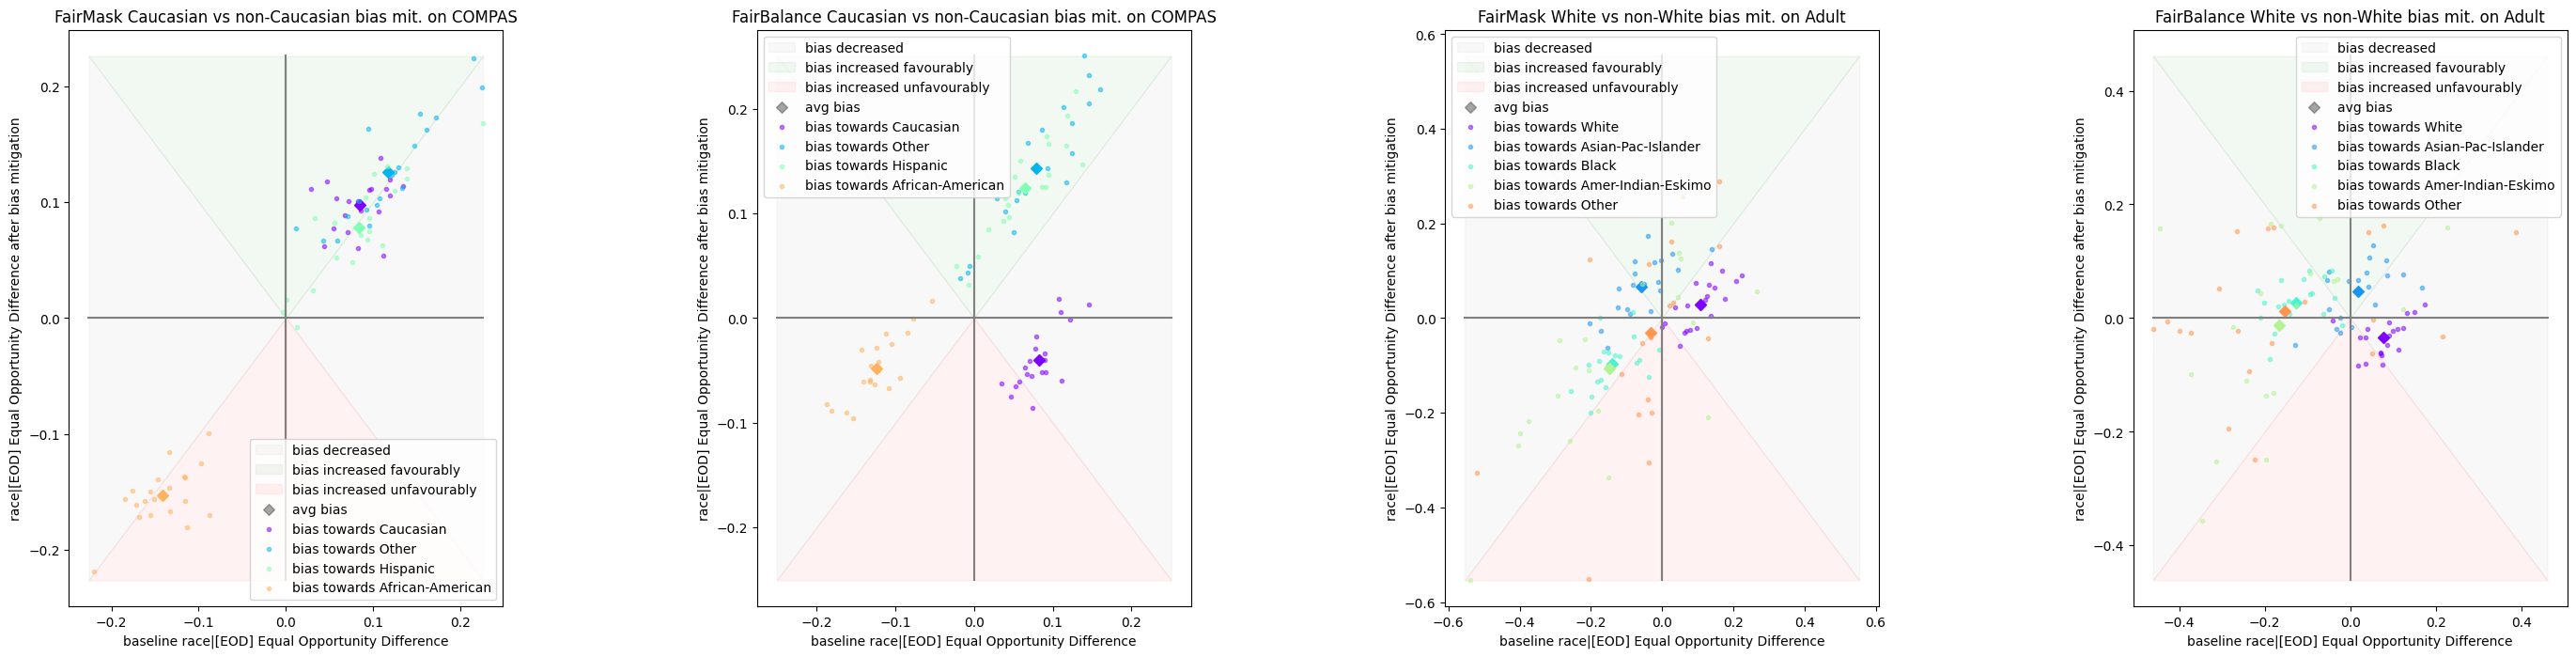

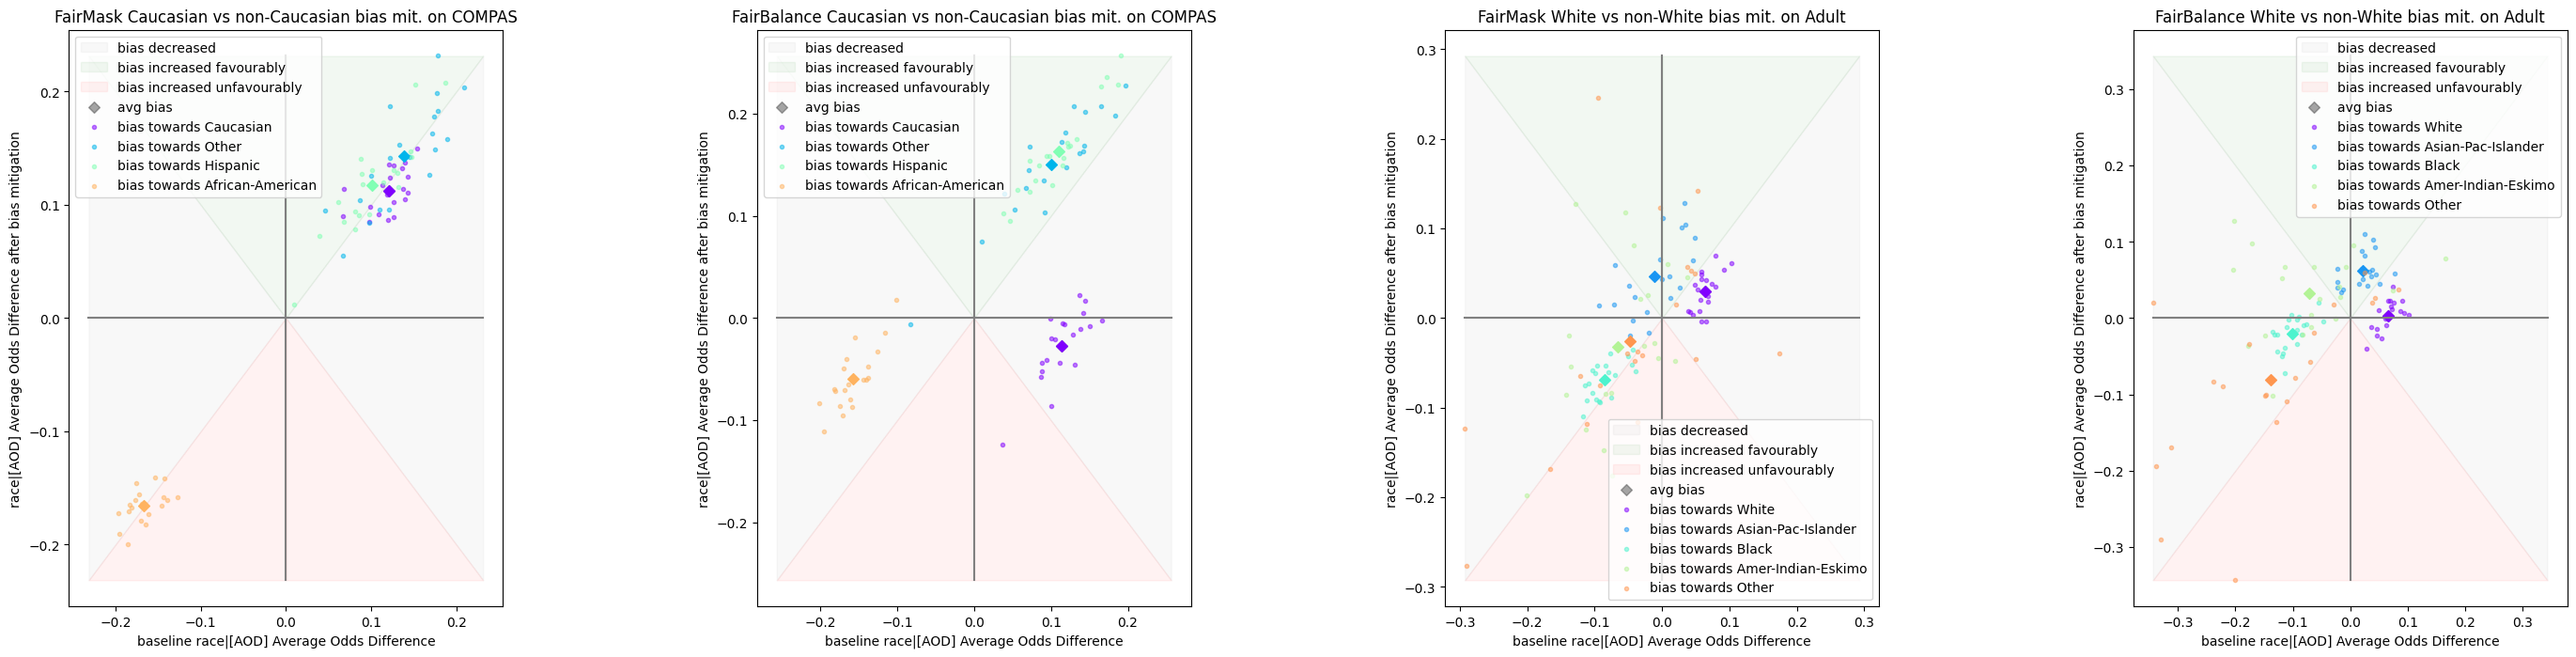

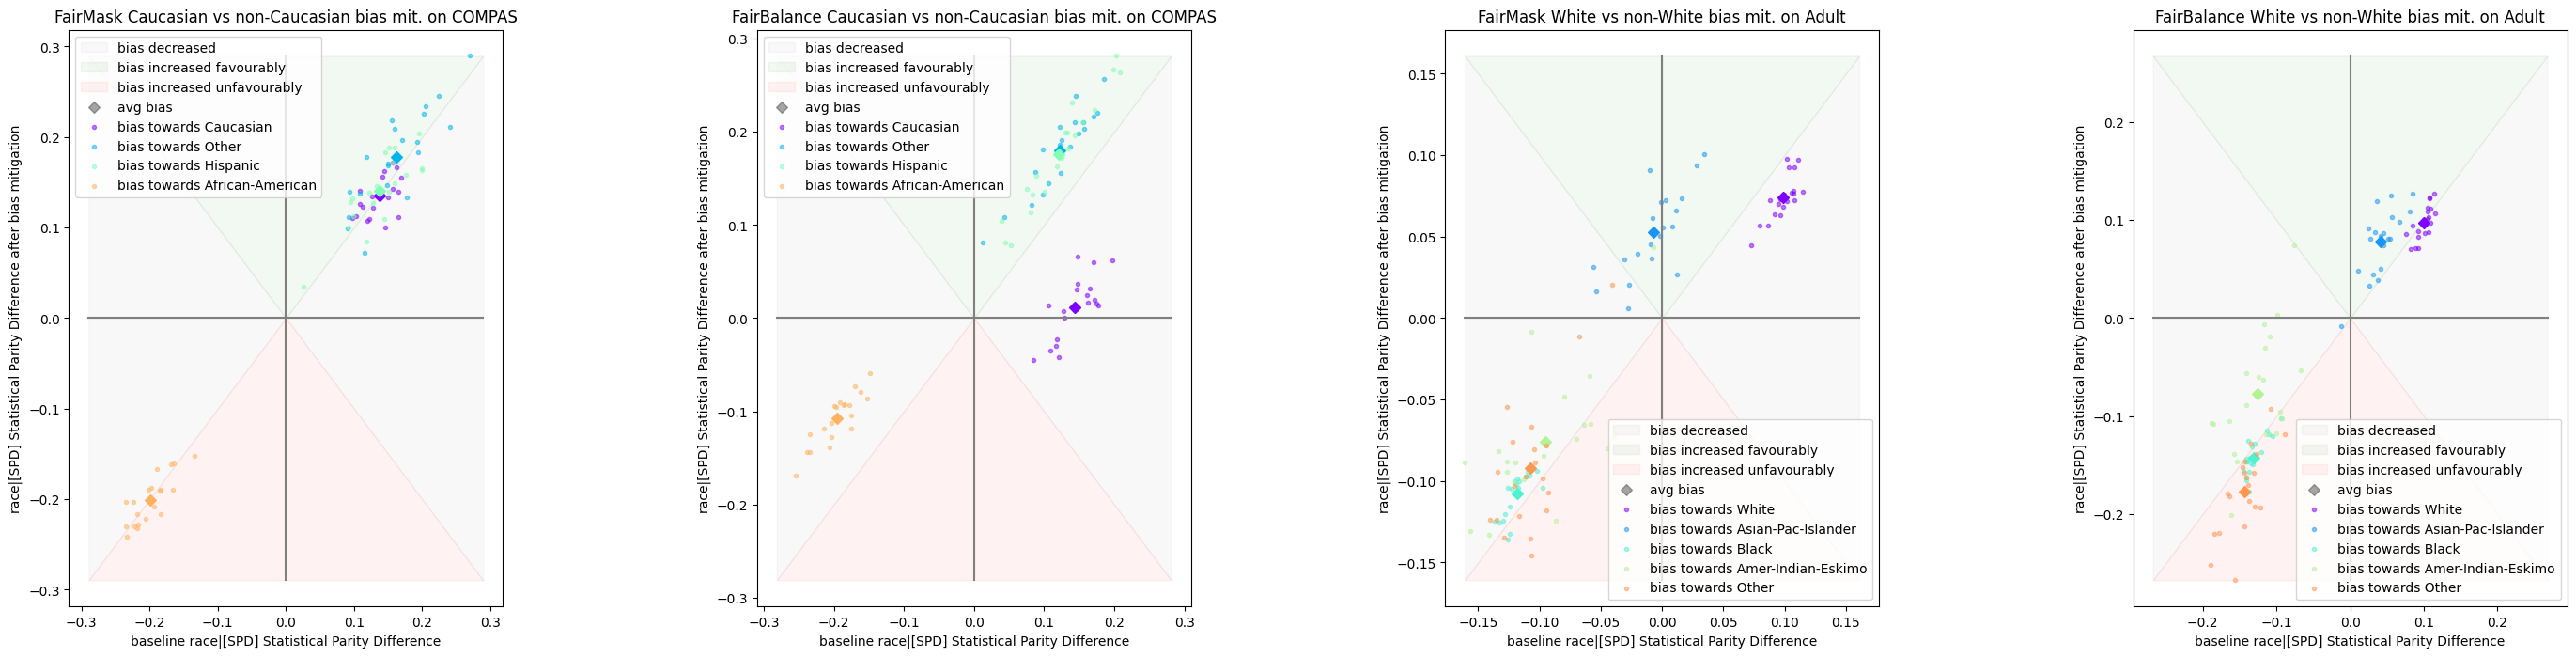

In [ ]:
reps = 20
for m in [Metrics.EOD, Metrics.AOD, Metrics.SPD]:
    metric = 'race|'+m
    m_to_eval = m
    run_change_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])


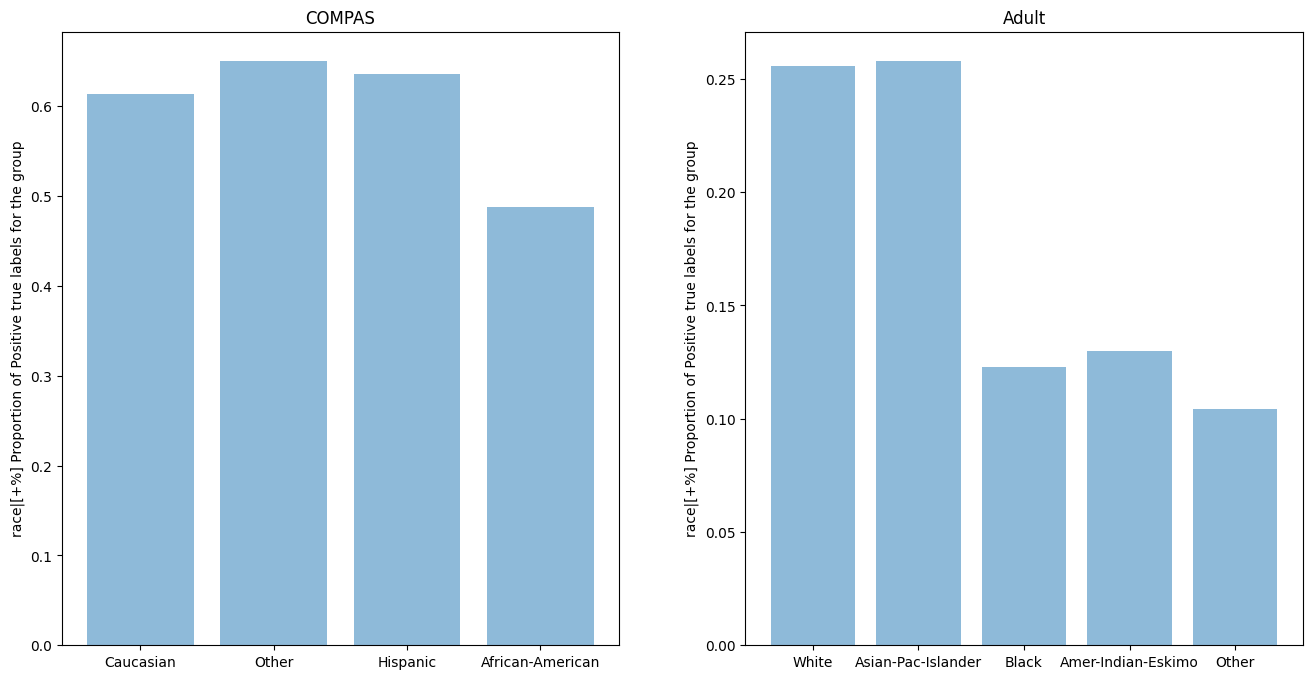

In [ ]:
reps = 15
metric = 'race|'+Metrics.T_POS
m_to_eval = Metrics.T_POS
run_fb_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])

In [ ]:
reps = 1
metric = Metrics.DF # 
m_to_eval = metric
run_experiment_group(reps, metric, attrs = ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

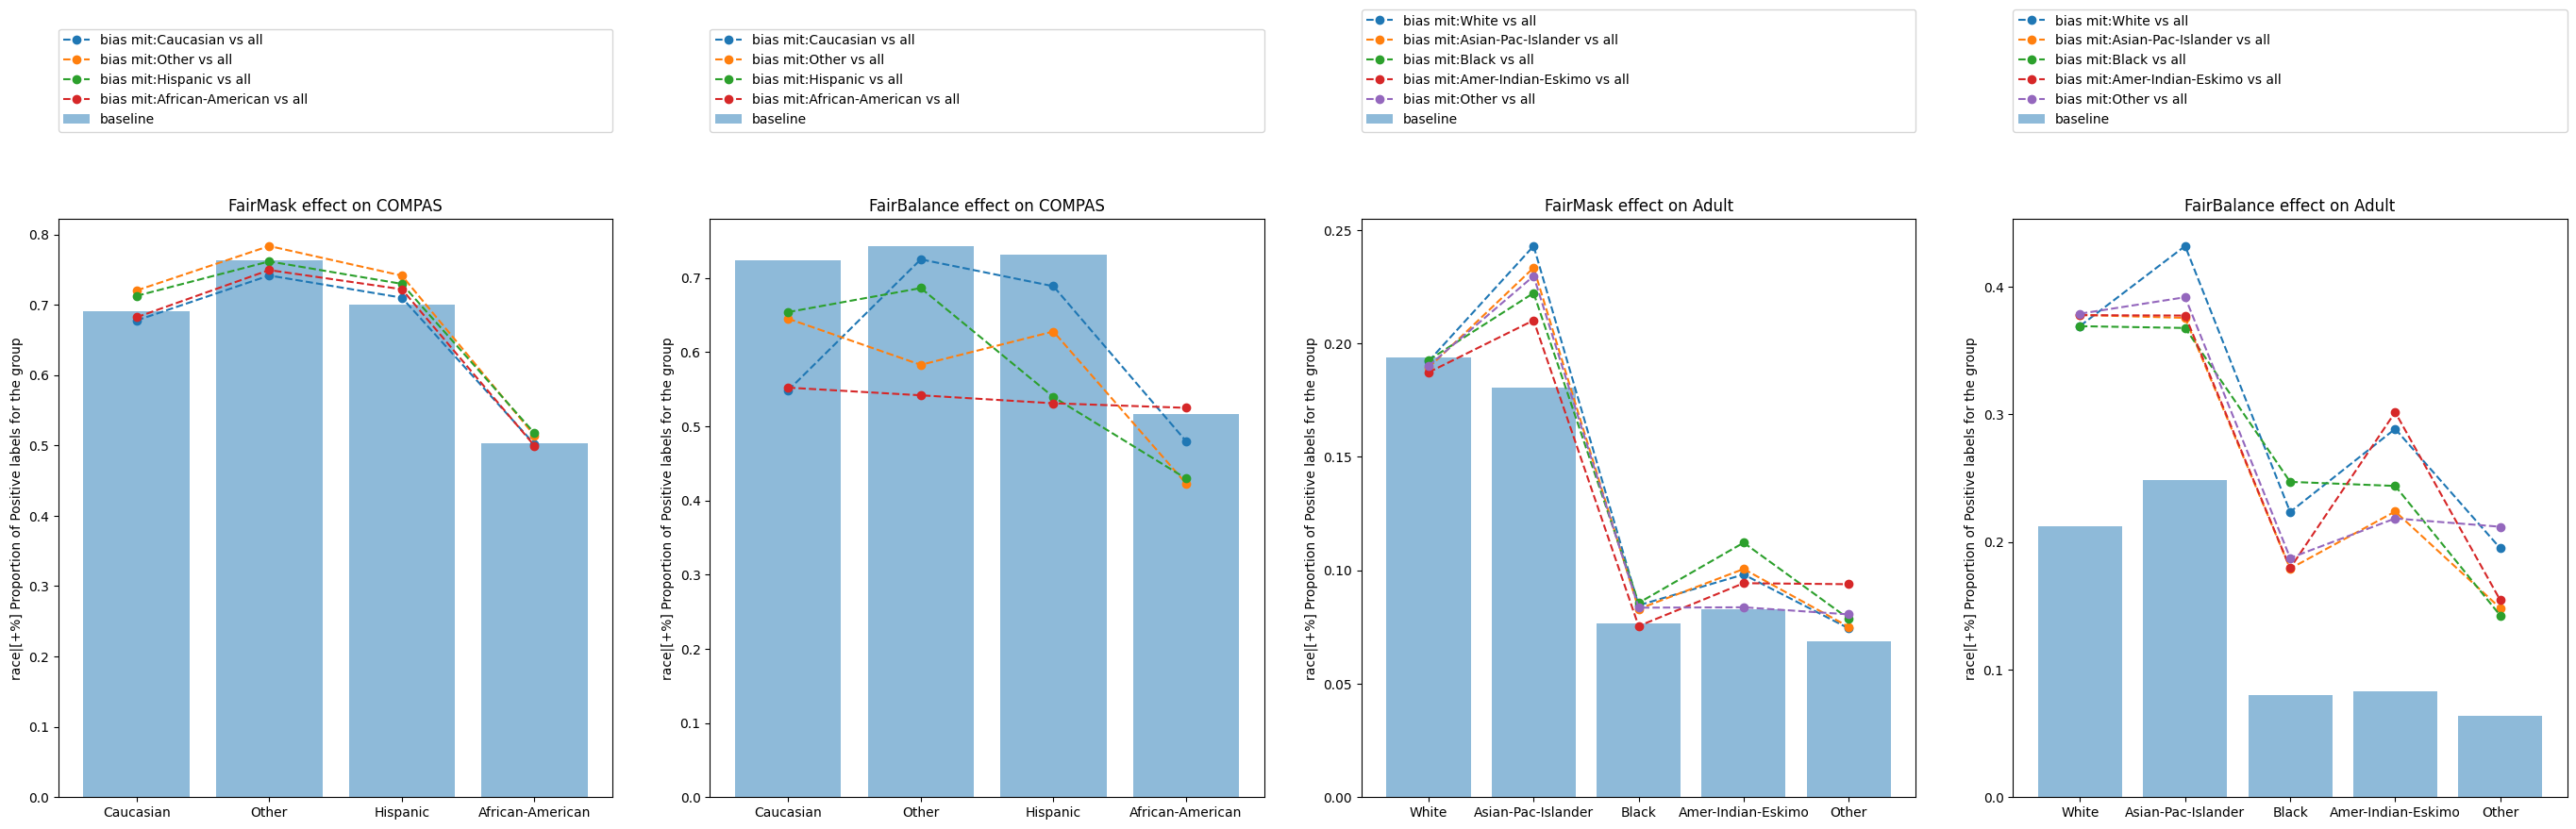

In [ ]:
# proportion of positive lables for each race
reps = 20
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_experiment_group(reps, metric, attrs= ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
##run_experiment_group(reps, metric, metrics_to_eval=[m_to_eval])

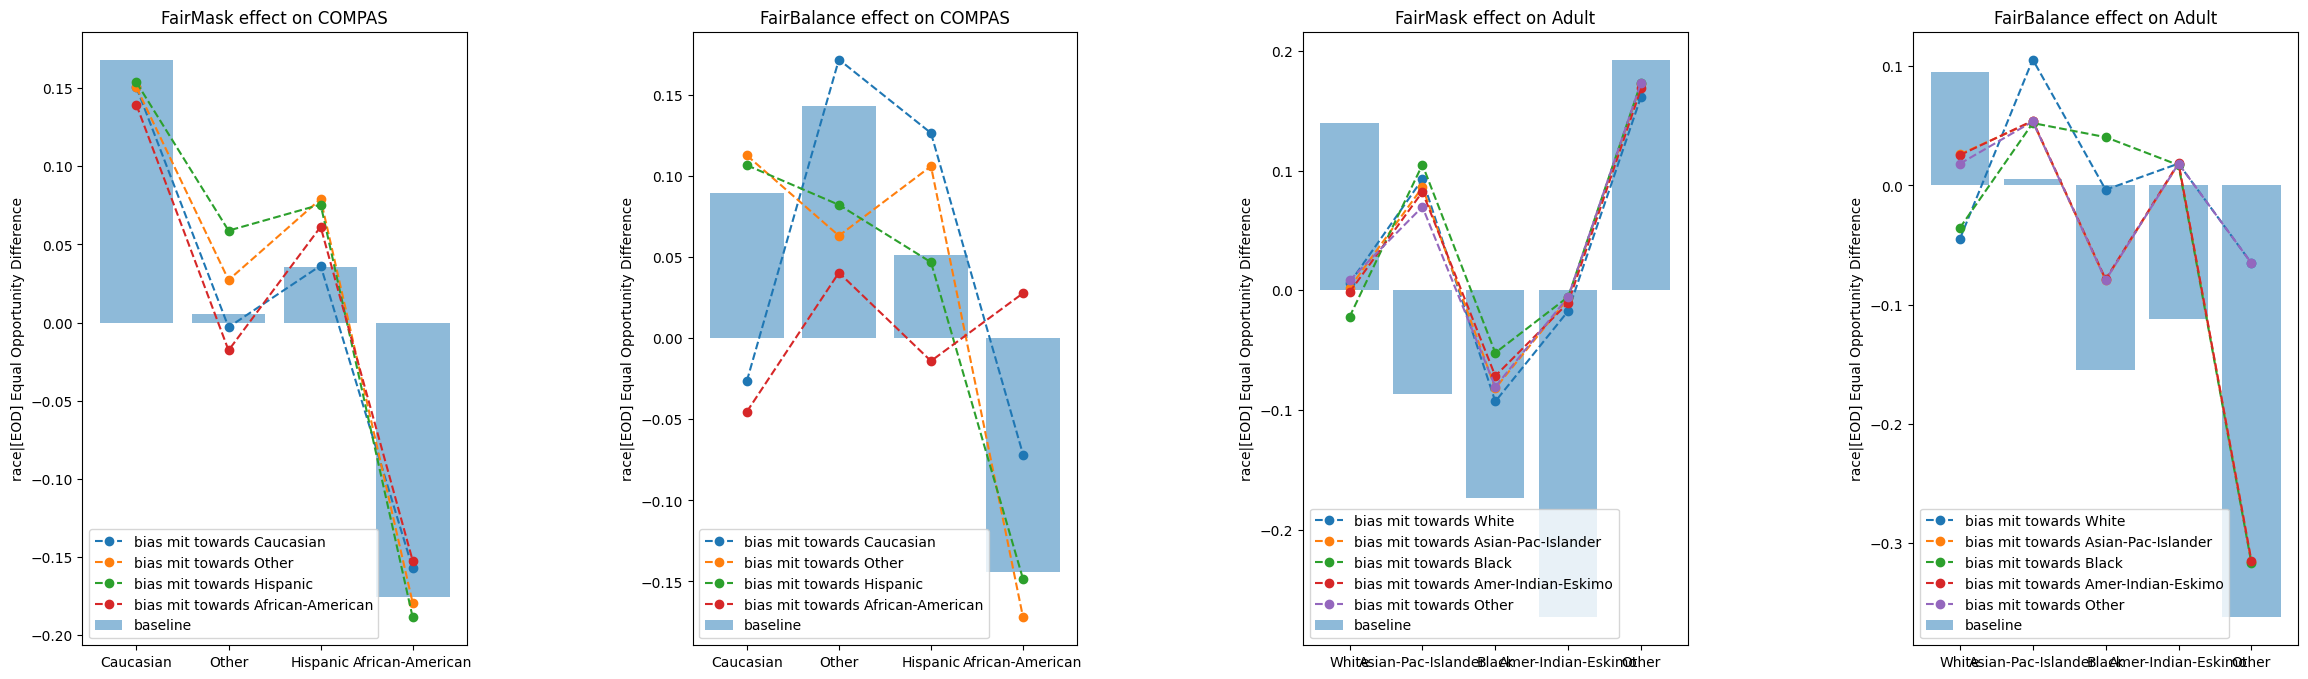

In [ ]:
reps = 1
metric =  'race|'+Metrics.EOD
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.EOD])

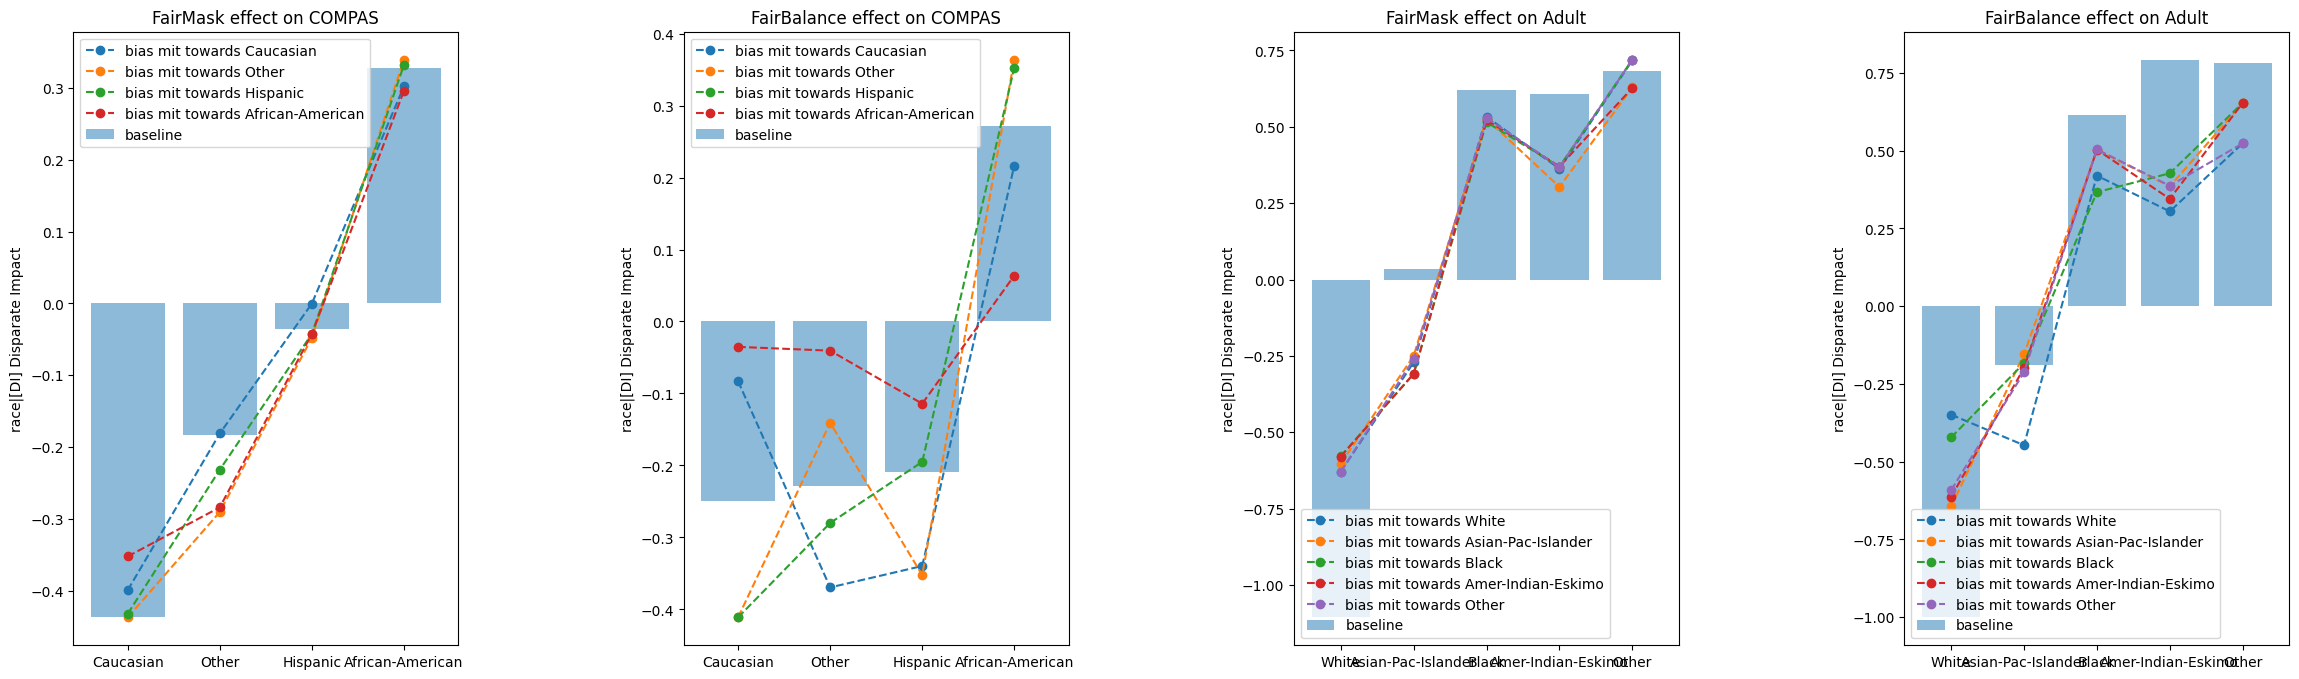

In [ ]:
reps = 1
metric =  'race|'+Metrics.DI
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.DI])

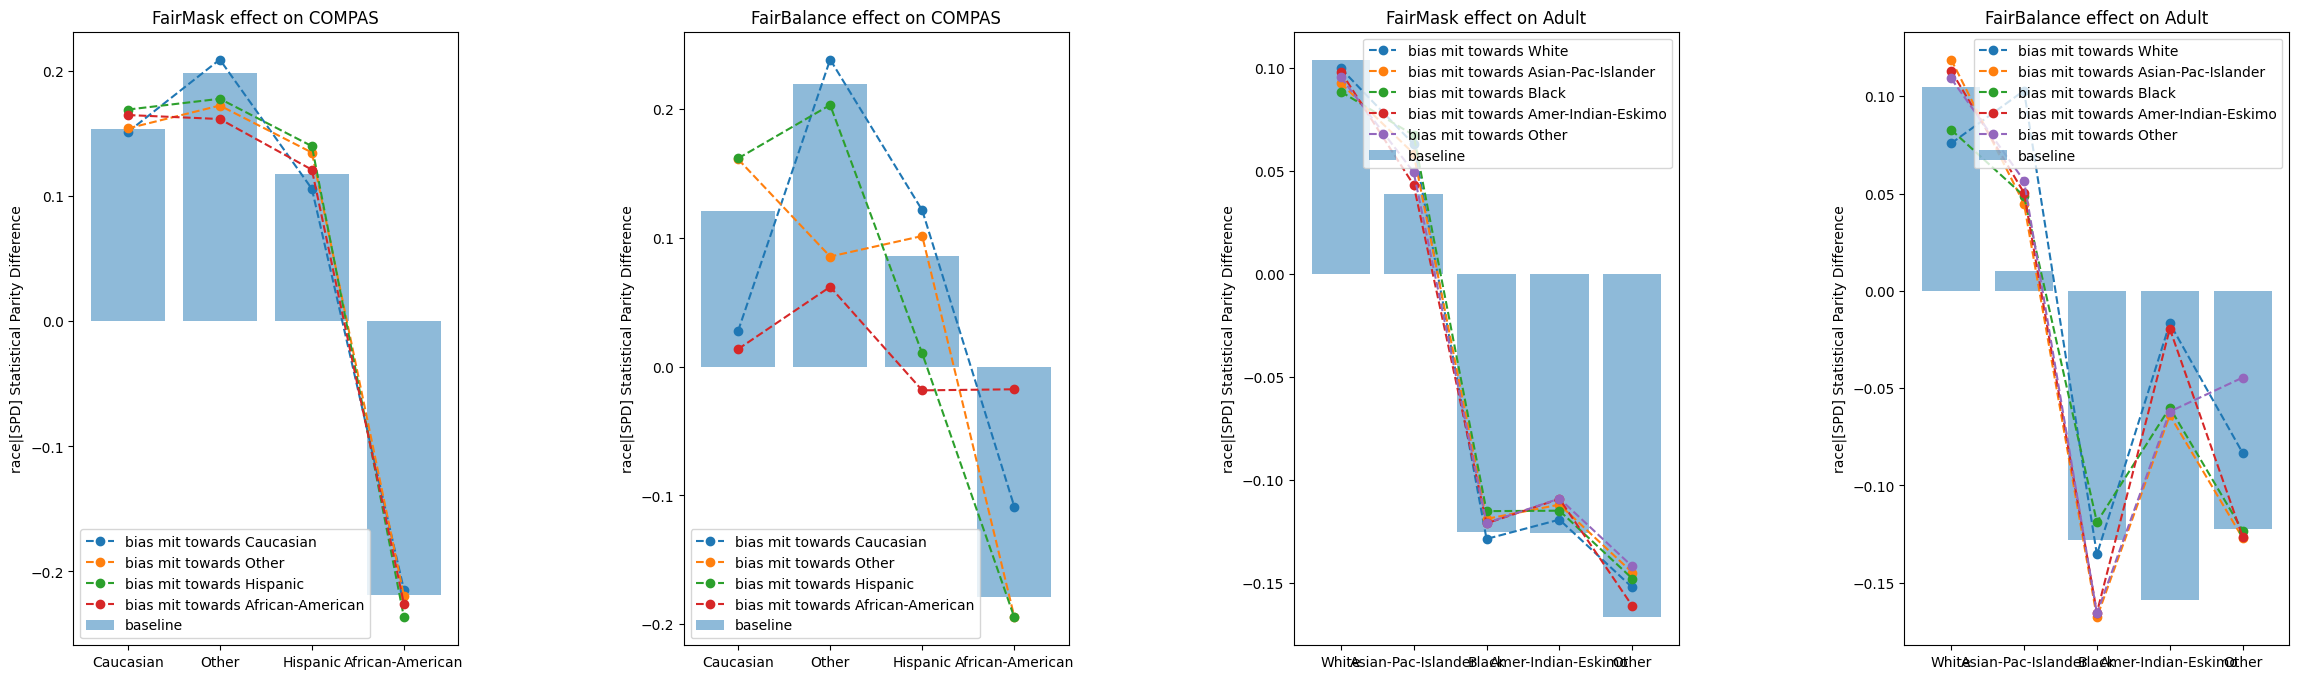

In [ ]:
reps = 1
metric =  'race|'+Metrics.SPD
run_experiment_group(reps, metric, metrics_to_eval=[Metrics.SPD])

In [ ]:
"""
OBSERVATIONS:

Fairmask does not do much on Compas (presumanbly cause data is so biased)
And does maybe a bit on Adult

Fairbalance just basically tweeks the treshold of positive vs negative outcomes. But just as before groups are discriminated at similar proportions


A different ML method does not really do much to change this as the logib behind this remains the same.
Mayhaps it changes how much the undersampled grops are discriminated against but thats it. 

In every single one of the cases there are subgroups for whom discrimination is iincreased in every example!

TODO:
see what if we ignore gender vs dont
combine some tiny groups into Other
what metric works the best on disproportionate groups
report variance.

"""
pass

## RUNNING EXPERIMENTS WITH FEWER RACES

In [252]:
mls = { # bias mitigation method, ML algo, secondary ML alg, preprocessing, other
    "FB Baseline":(Tester.BASE_ML,      Model.LG_R, None, "FairBalance merge races", other_fb), 
    "FairBalance":(Tester.FAIRBALANCE,  Model.LG_R, None, "FairBalance merge races", other_fb), 

    "FM Baseline":(Tester.BASE_ML,      Model.RF_C, None,       "FairMask merge races",    other), 
    "FairMask":   (Tester.FAIRMASK,     Model.RF_C, Model.DT_R, "FairMask merge races",    other)
}

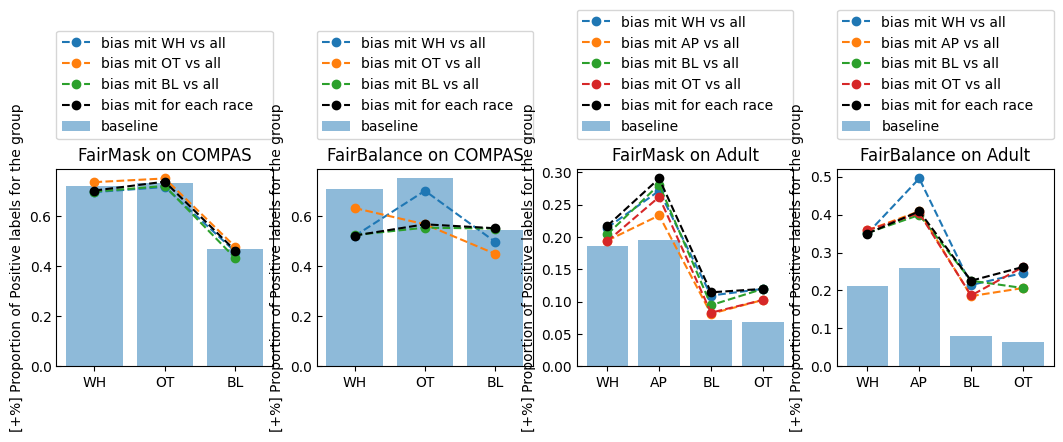

In [254]:
reps = 1
plot_h = 2.25
metric = Metrics.POS
run_experiment_group_mit_for_all(reps, metric, mls, metrics_to_eval=[metric], attrs=["race", "sex"])

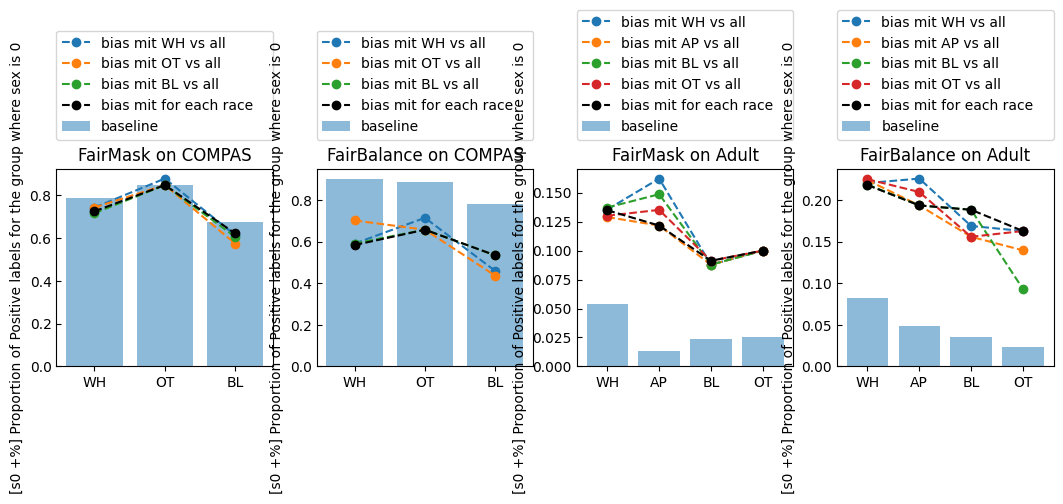

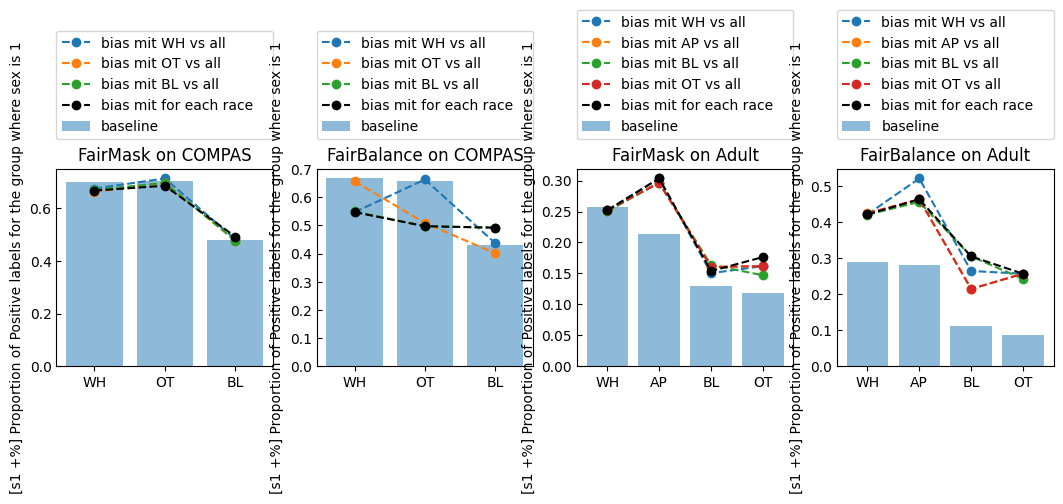

In [253]:
reps = 1
plot_h = 2.25
metric = Metrics.POS_SEX0
run_experiment_group_mit_for_all(reps, metric, mls, metrics_to_eval=[metric], attrs=["race", "sex"])
metric = Metrics.POS_SEX1
run_experiment_group_mit_for_all(reps, metric, mls, metrics_to_eval=[metric], attrs=["race", "sex"])

In [48]:
# proportion of positive lables for each race for one run
reps = 1
metric = 'race|'+Metrics.POS
m_to_eval = Metrics.POS
run_fb_experiment_group(reps, metric, mls, ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_experiment_group(reps, metric, mls, metrics_to_eval=[m_to_eval])

NameError: name 'mls' is not defined

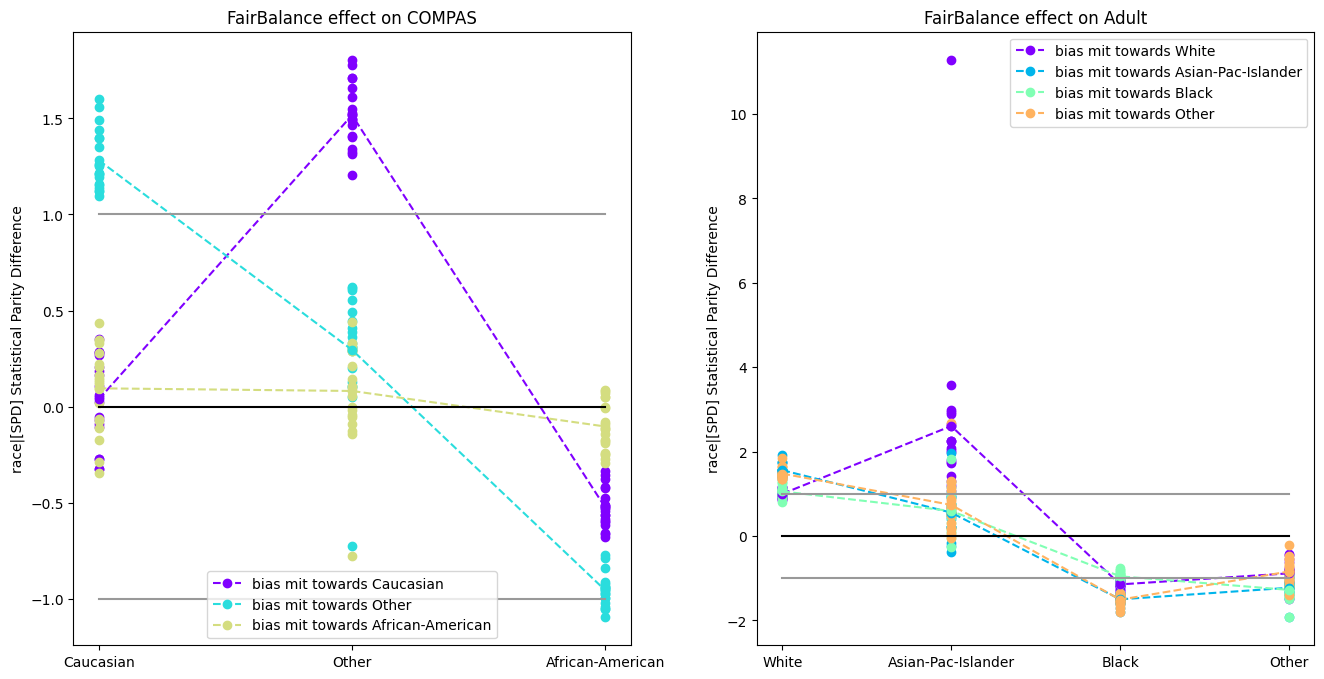

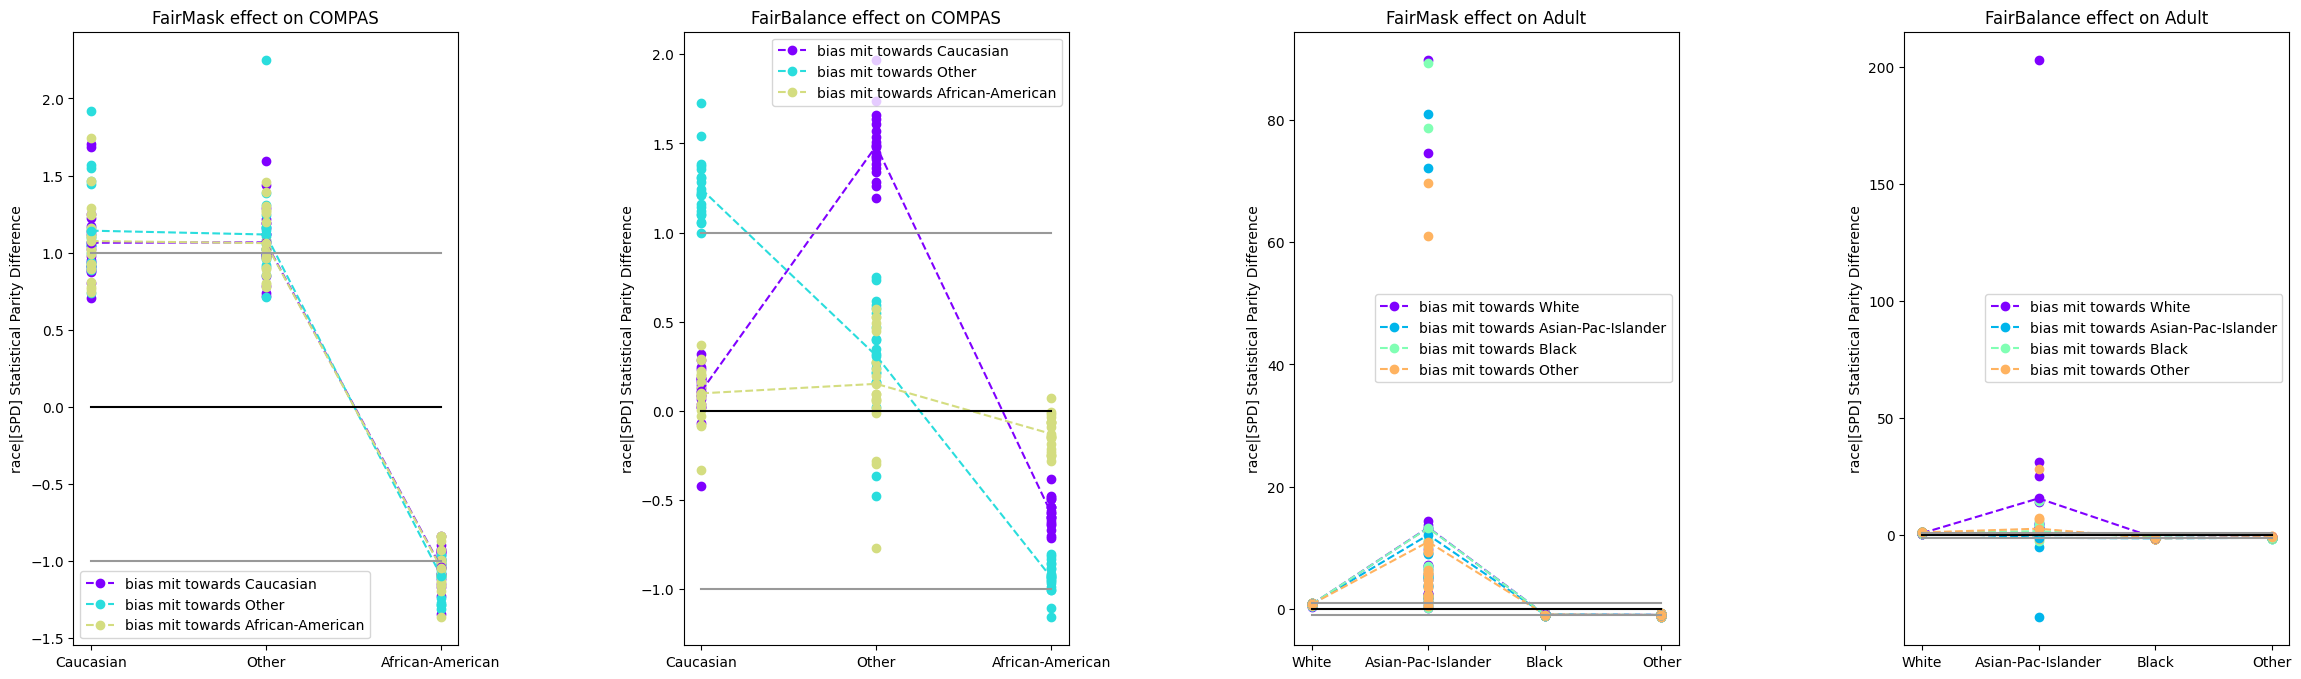

In [ ]:
# Change in bias scale. (change in the absolute value of spd) 
reps = 20
metric =  'race|'+Metrics.SPD
m_to_eval = Metrics.SPD
run_change_fb_experiment_group(reps, metric, mls, ["race"], metrics_to_eval=[m_to_eval])
# same but bias mitigated for sex and race
run_change_experiment_group(reps, metric, mls, metrics_to_eval=[m_to_eval])